In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '12G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark
spark = init_spark()
filename_data = 'Google-Playstore.csv'

df = spark.read.option("header", "true").csv(filename_data, mode="DROPMALFORMED")
print(df)
#Делаем поля определенным типом данных и удаляем не нужные столбцы
df = df.withColumn("Rating",df.Rating.cast(DoubleType())) \
    .withColumn("Price",df.Price.cast(DoubleType())) \
    .withColumn("Maximum Installs",df["Maximum Installs"].cast(IntegerType())) \
    .drop("App Name", "Installs", "Rating Count", "Minimum Installs", "Minimum Android", "Developer Id", "Developer Website","Developer Email", "Released", "Last Updated","Privacy Policy","Scraped Time", "Editors Choice","Currency")

print('Data overview')
df.printSchema()

total_app_count = df.count()
total_app_count

DataFrame[App Name: string, App Id: string, Category: string, Rating: string, Rating Count: string, Installs: string, Minimum Installs: string, Maximum Installs: string, Free: string, Price: string, Currency: string, Size: string, Minimum Android: string, Developer Id: string, Developer Website: string, Developer Email: string, Released: string, Last Updated: string, Content Rating: string, Privacy Policy: string, Ad Supported: string, In App Purchases: string, Editors Choice: string, Scraped Time: string]
Data overview
root
 |-- App Id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Maximum Installs: integer (nullable = true)
 |-- Free: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Ad Supported: string (nullable = true)
 |-- In App Purchases: string (nullable = true)



2312944

### Смотрим на нулевые значения

In [3]:
string_columns = ['Category', 'Installs', 'Free', 'Size', 'Content Rating', 'Ad Supported', 'In App Purchases', 'App Id']
numeric_columns = ['Rating','Price', 'Maximum Installs']
#Пропущенные значения
def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,App Id,Category,Rating,Maximum Installs,Free,Price,Size,Content Rating,Ad Supported,In App Purchases
0,0,0,22913,37,0,19,196,0,4,2


### Удаляем нулевые значения

In [4]:
#Пропущенные значения в рейтинге и цене убирать не будем
df = df.dropna(subset=['Size'])
# df = df.withColumn('Ad Supported', when(~col('Ad Supported').isin(['True', 'False']), 'True').otherwise(col('Ad Supported')))
df = df.dropna(subset=['Ad Supported'])
df = df.dropna(subset=['In App Purchases'])
df = df.dropna(subset=['App Id'])
avg_valueP = df.select(mean('Price')).collect()[0]['avg(Price)']
avg_value = df.select(mean('Rating')).collect()[0]['avg(Rating)']
print(avg_valueP)
print(avg_value)
df = df.withColumn('Price', when(col('Price').isin([0]) | col('Price').isNull(),avg_valueP).otherwise(col('Price')))
df = df.dropna(subset=['Price'])
df = df.withColumn('Rating', when(col('Rating').isin([0]) | col('Rating').isNull(),avg_value).otherwise(col('Rating')))
df = df.dropna(subset=['Rating'])
df = df.dropna(subset=['Maximum Installs'])
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns,numeric_columns)])



2.2742768824640542
2.203142098575241


,App Id,Category,Rating,Maximum Installs,Free,Price,Size,Content Rating,Ad Supported,In App Purchases
0,0,0,0,0,0,0,0,0,0,0


### Описание числовых столбцов

In [5]:
'Data frame describe (numeric columns only):'
df.select(df.Rating, df.Price, df['Maximum Installs']).describe().toPandas()

'Data frame describe (numeric columns only):'

,summary,Rating,Price,Maximum Installs
0,count,2312707,2312707,2312707
1,mean,3.2126651496838754,4.495567979159181,251732.33606548517
2,stddev,1.0720595416902043,3287.832061459293,8564895.431341162
3,min,1.0,0.194824,0
4,max,5.0,5000000.0,2123105347


### Межквантильный диапазон (измеряем разброс средних значений)


In [6]:
for column in ['Maximum Installs']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))    

df.select(df.Rating, df.Price, df['Maximum Installs']).describe().toPandas()
# df.toPandas().to_csv('mycsv.csv')

,summary,Rating,Price,Maximum Installs
0,count,1905063,1905063,1905063
1,mean,3.059290744731102,2.3429015827215456,1966.0485794957963
2,stddev,1.0829937628012414,2.800176856916892,3557.531249169308
3,min,1.0,0.194824,0
4,max,5.0,400.0,18258


### Топ 10 категорий приложений

Top 10 app categories:


/tmp/ipykernel_3952/1592298283.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_app_category_df['Category'],


,Category,count,percentage
0,Education,206819,8.941807
1,Business,134822,5.829021
2,Music & Audio,133247,5.760926
3,Tools,112450,4.861769
4,Entertainment,106610,4.609277
5,Lifestyle,100278,4.335514
6,Books & Reference,93156,4.027594
7,Health & Fitness,73859,3.193290
8,Food & Drink,69645,3.011098
9,Productivity,68985,2.982562


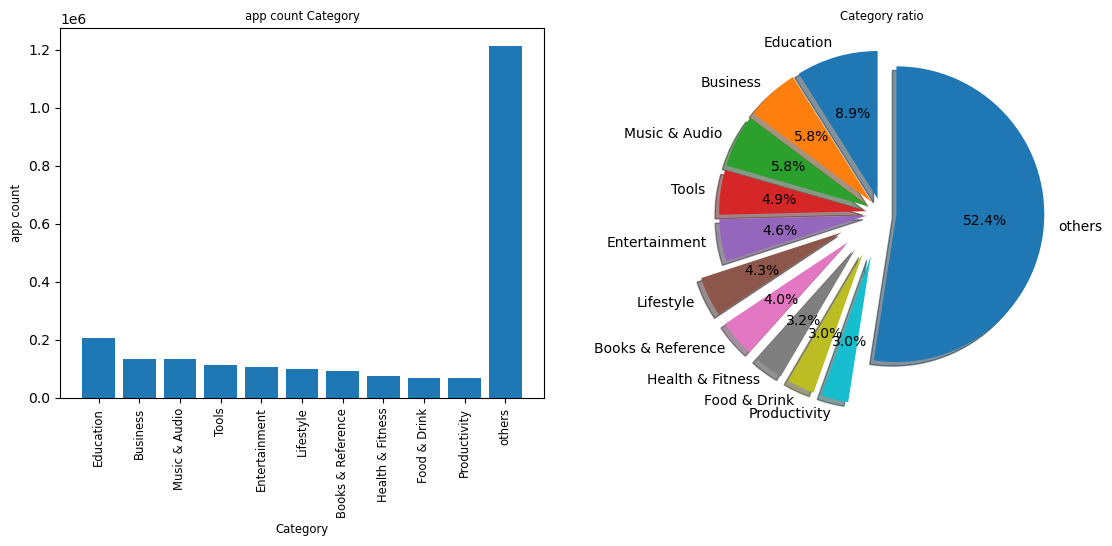

In [7]:
highest_app_category_df = df.select(df.Category, df['App Id']) \
    .groupBy(df.Category) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()

highest_app_category_df['percentage'] = highest_app_category_df['count'] \
    / total_app_count * 100

others = {
    'Category': 'others', 
    'count': total_app_count - np.sum(highest_app_category_df['count']), 
    'percentage': 100 - np.sum(highest_app_category_df['percentage'])
}

highest_app_category_df = pd.concat([highest_app_category_df,pd.DataFrame.from_dict([others])])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_app_category_df['Category'], 
                     height=highest_app_category_df['count'])
title0 =  axs[0].set_title('app count Category', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Category', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('app count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_app_category_df['Category'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3,0.3,0.3,0.3,0.3,0.1)
title1 = axs[1].set_title('Category ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_app_category_df['percentage'],
    labels=highest_app_category_df['Category'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 10 app categories:')
highest_app_category_df




### Категория и наличие поддержки внутри приложений

/tmp/ipykernel_3952/1691270063.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  a = fig.tight_layout()


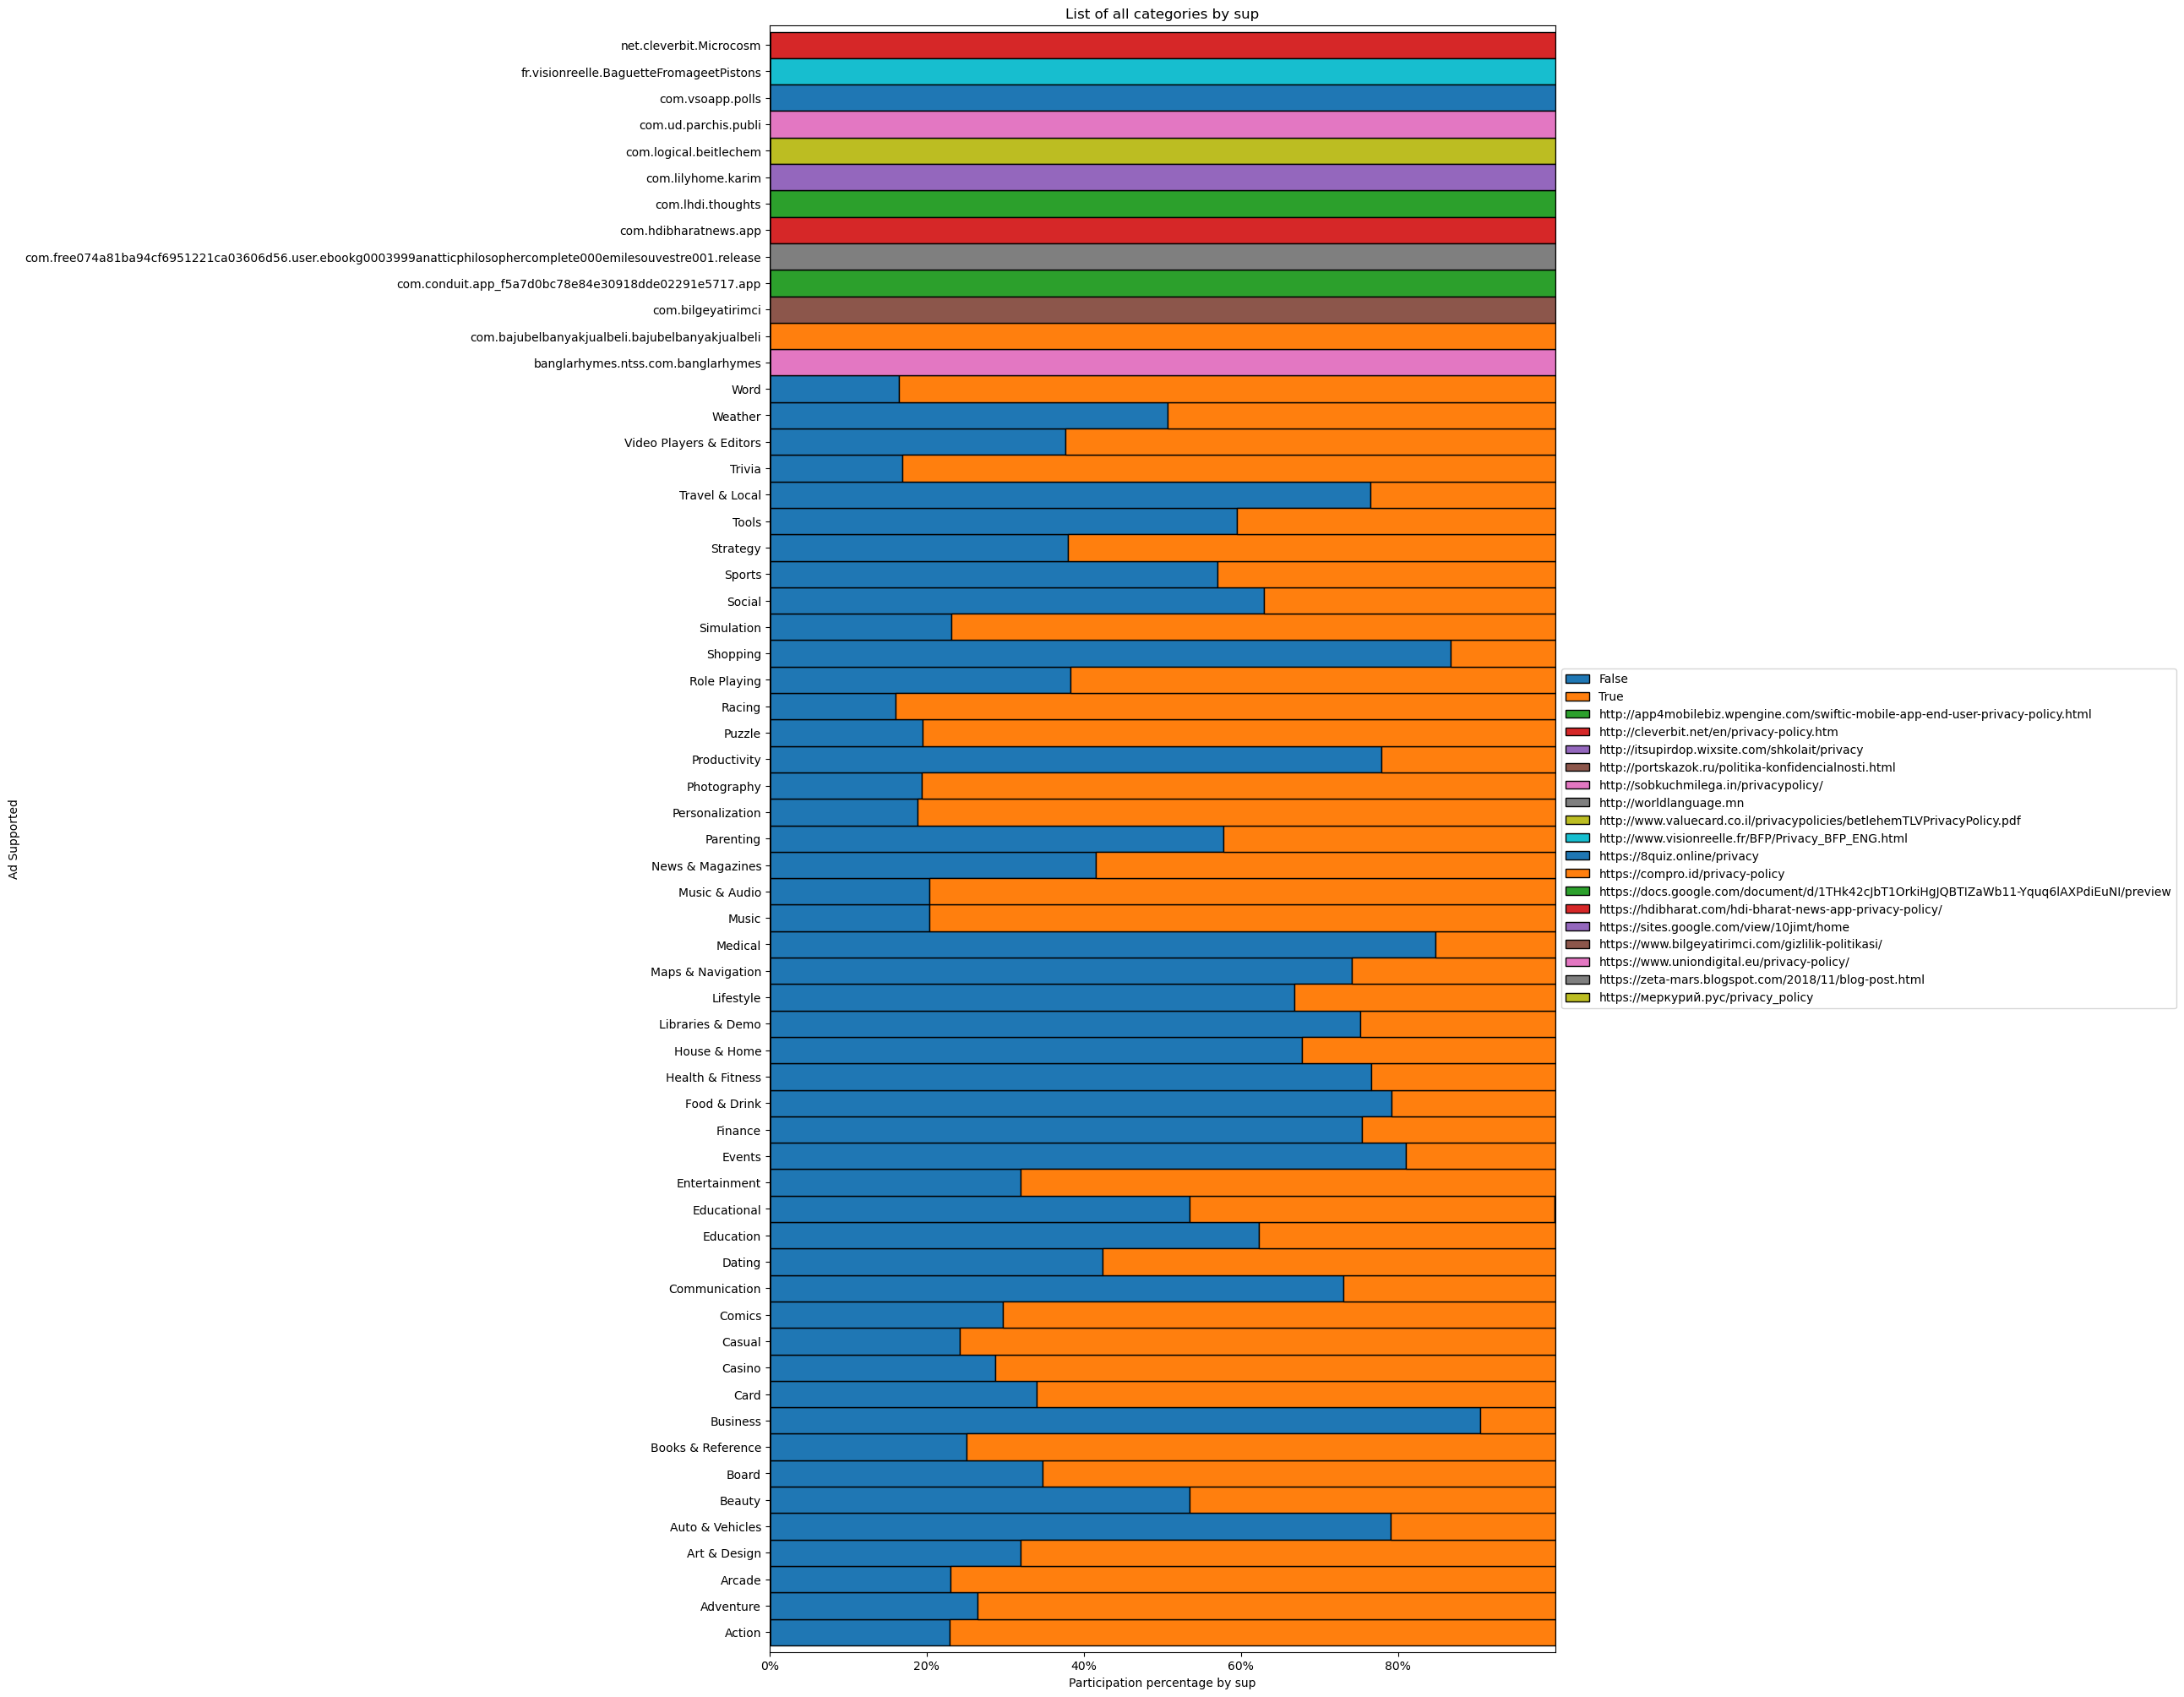

In [8]:
category_by_sup_df = df.groupBy(df.Category, df['Ad Supported']).count().toPandas()

sup = category_by_sup_df['Ad Supported'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = category_by_sup_df.groupby(['Category', 'Ad Supported'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all categories by sup')
ylabel = plt.ylabel('Ad Supported');
xlabel = plt.xlabel('Participation percentage by sup');
legend = plt.legend(
    sorted(sup), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

### Топ 10 категорий приложений с поддержкой и без

In [9]:
category_by_sup_df = df.groupBy(df.Category, df['Ad Supported']).count().toPandas().pivot_table(
    index="Category", columns="Ad Supported", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
category_by_sup_df['всего'] = 0
for s in sup:
    category_by_sup_df['всего'] += category_by_sup_df[s]
    
category_by_sup_df['процент'] = category_by_sup_df['всего'] / np.sum(category_by_sup_df['всего']) * 100

for s in sup:
    category_by_sup_df['процент ' + s + ' поддержка'] = \
        (category_by_sup_df[s] / category_by_sup_df['всего']) * 100

top_category_by_sup_df = category_by_sup_df.sort_values(
    by='процент', ascending=False
).head(10)

others = {'Category' : 'others'}
for column in [*['всего', 'процент'], *sup,]:
    value = np.sum(category_by_sup_df[column]) - np.sum(top_category_by_sup_df[column])
    others.update({column: value})

for s in sup:
    value = (others[s] / others['всего']) * 100
    others.update({'процент ' + s  + ' поддержка': value})
    
top_category_by_sup_df = pd.concat([top_category_by_sup_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

top_category_by_sup_df

,Category,False,True,http://app4mobilebiz.wpengine.com/swiftic-mobile-app-end-user-privacy-policy.html,http://cleverbit.net/en/privacy-policy.htm,http://itsupirdop.wixsite.com/shkolait/privacy,http://portskazok.ru/politika-konfidencialnosti.html,http://sobkuchmilega.in/privacypolicy/,http://worldlanguage.mn,http://www.valuecard.co.il/privacypolicies/betlehemTLVPrivacyPolicy.pdf,...,процент http://portskazok.ru/politika-konfidencialnosti.html поддержка,процент http://sobkuchmilega.in/privacypolicy/ поддержка,процент http://www.visionreelle.fr/BFP/Privacy_BFP_ENG.html поддержка,процент http://www.valuecard.co.il/privacypolicies/betlehemTLVPrivacyPolicy.pdf поддержка,процент https://8quiz.online/privacy поддержка,процент https://меркурий.рус/privacy_policy поддержка,процент https://hdibharat.com/hdi-bharat-news-app-privacy-policy/ поддержка,процент http://app4mobilebiz.wpengine.com/swiftic-mobile-app-end-user-privacy-policy.html поддержка,процент https://www.uniondigital.eu/privacy-policy/ поддержка,процент https://www.bilgeyatirimci.com/gizlilik-politikasi/ поддержка
0,Education,128757,78061,0,0,0,0,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Business,121892,12929,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000742,0.000000,0.000000,0.000000,0.000000
2,Music & Audio,27023,106224,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Tools,66828,45622,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Entertainment,34094,72516,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Lifestyle,66940,33338,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Books & Reference,23348,69808,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Health & Fitness,56573,17286,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Food & Drink,55157,14488,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Productivity,53727,15258,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Найдём 10 категорий, которые включают поддержку

In [10]:
top_category_by_sup_df = category_by_sup_df.sort_values(
    by='процент True поддержка', ascending=False
).head(10).reset_index(drop=True)

top_category_by_sup_df

,Category,False,True,http://app4mobilebiz.wpengine.com/swiftic-mobile-app-end-user-privacy-policy.html,http://cleverbit.net/en/privacy-policy.htm,http://itsupirdop.wixsite.com/shkolait/privacy,http://portskazok.ru/politika-konfidencialnosti.html,http://sobkuchmilega.in/privacypolicy/,http://worldlanguage.mn,http://www.valuecard.co.il/privacypolicies/betlehemTLVPrivacyPolicy.pdf,...,процент http://portskazok.ru/politika-konfidencialnosti.html поддержка,процент http://sobkuchmilega.in/privacypolicy/ поддержка,процент http://www.visionreelle.fr/BFP/Privacy_BFP_ENG.html поддержка,процент http://www.valuecard.co.il/privacypolicies/betlehemTLVPrivacyPolicy.pdf поддержка,процент https://8quiz.online/privacy поддержка,процент https://меркурий.рус/privacy_policy поддержка,процент https://hdibharat.com/hdi-bharat-news-app-privacy-policy/ поддержка,процент http://app4mobilebiz.wpengine.com/swiftic-mobile-app-end-user-privacy-policy.html поддержка,процент https://www.uniondigital.eu/privacy-policy/ поддержка,процент https://www.bilgeyatirimci.com/gizlilik-politikasi/ поддержка
0,Racing,982,5152,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Word,1018,5161,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Trivia,1572,7736,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Personalization,12548,54288,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Photography,4696,19528,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Puzzle,7834,32477,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Music & Audio,27023,106224,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Music,588,2306,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Action,4394,14758,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Arcade,10663,35654,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Распределение по ценам

array([[<AxesSubplot: title={'center': 'Maximum Installs'}>]],
      dtype=object)

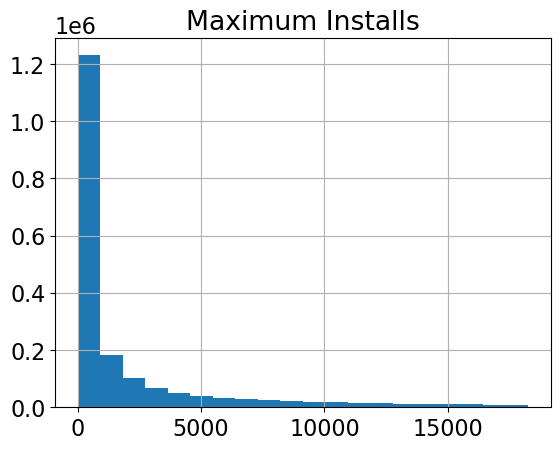

In [11]:
df.select(df['Maximum Installs'], df['App Id']).toPandas().hist(column='Maximum Installs',bins=20)

<AxesSubplot: ylabel='Category'>

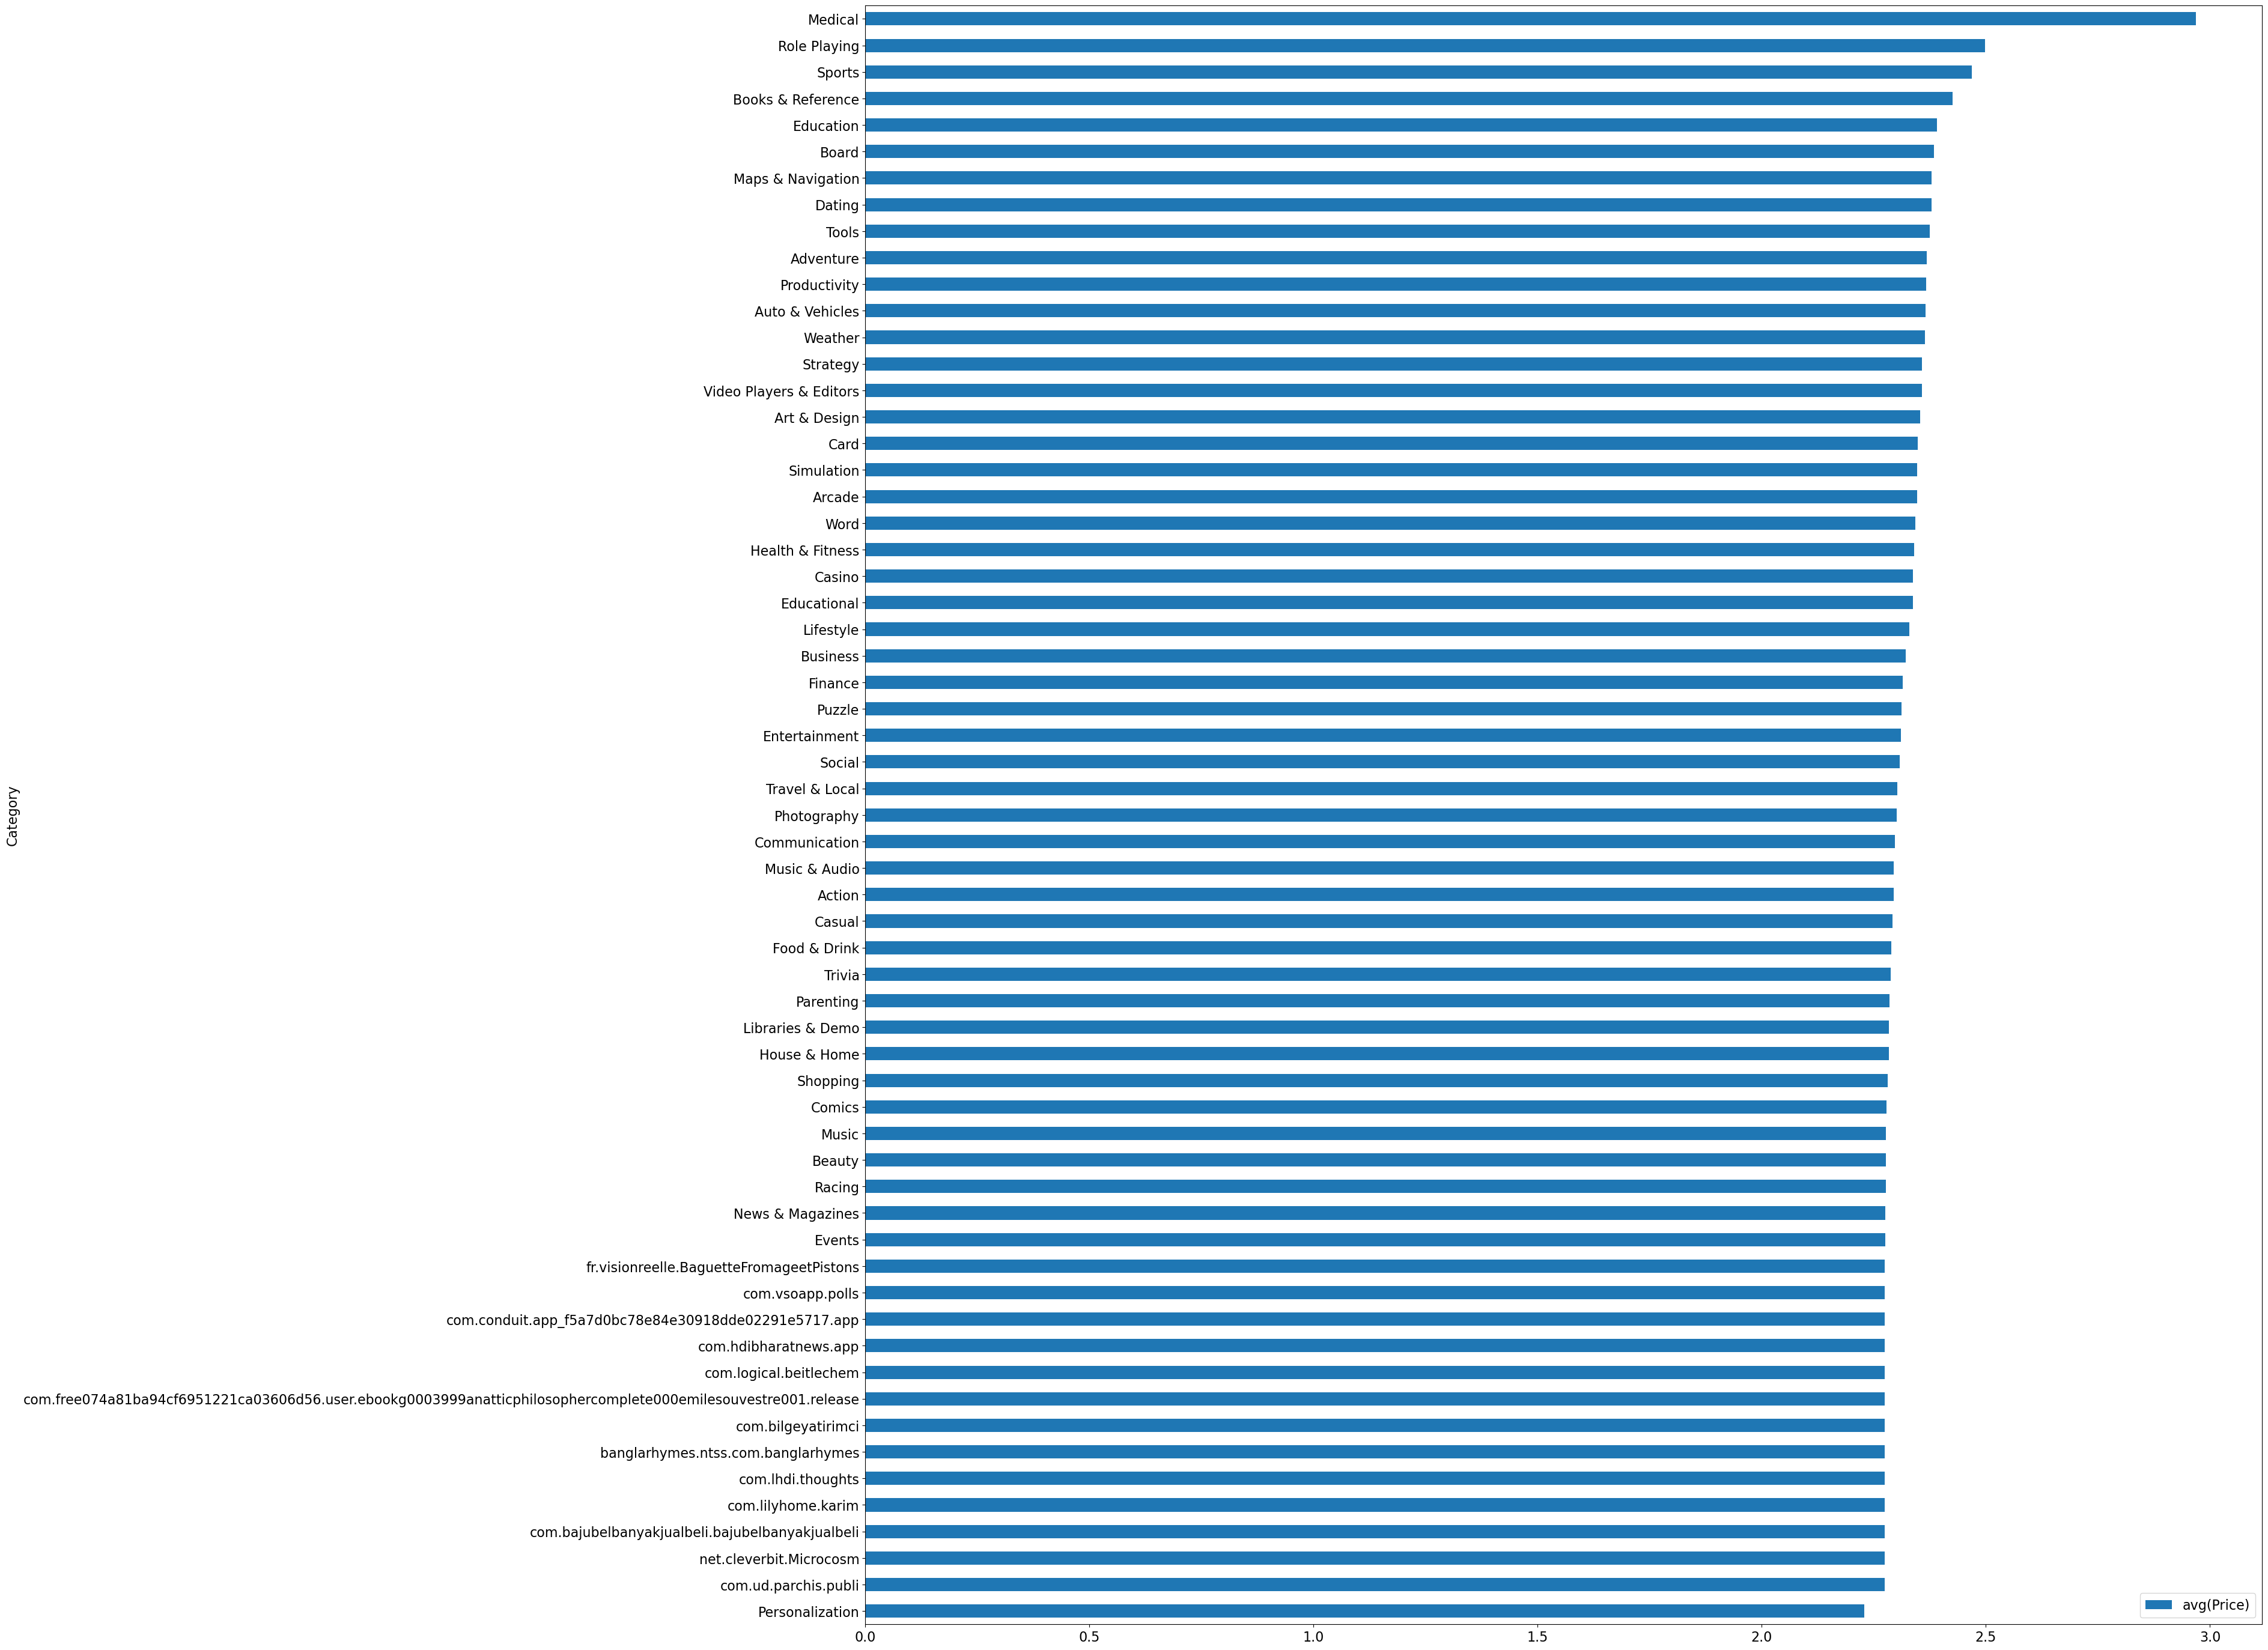

In [12]:
df.select(df.Category, df.Price) \
    .groupBy(df.Category) \
    .avg('Price') \
    .toPandas() \
    .sort_values(by='avg(Price)') \
    .plot.barh(column="avg(Price)", x='Category', figsize=(30,35))

### Узнаем, какие категории скачивали больше всех  и отобразим топ 10 категорий по скачиваниям

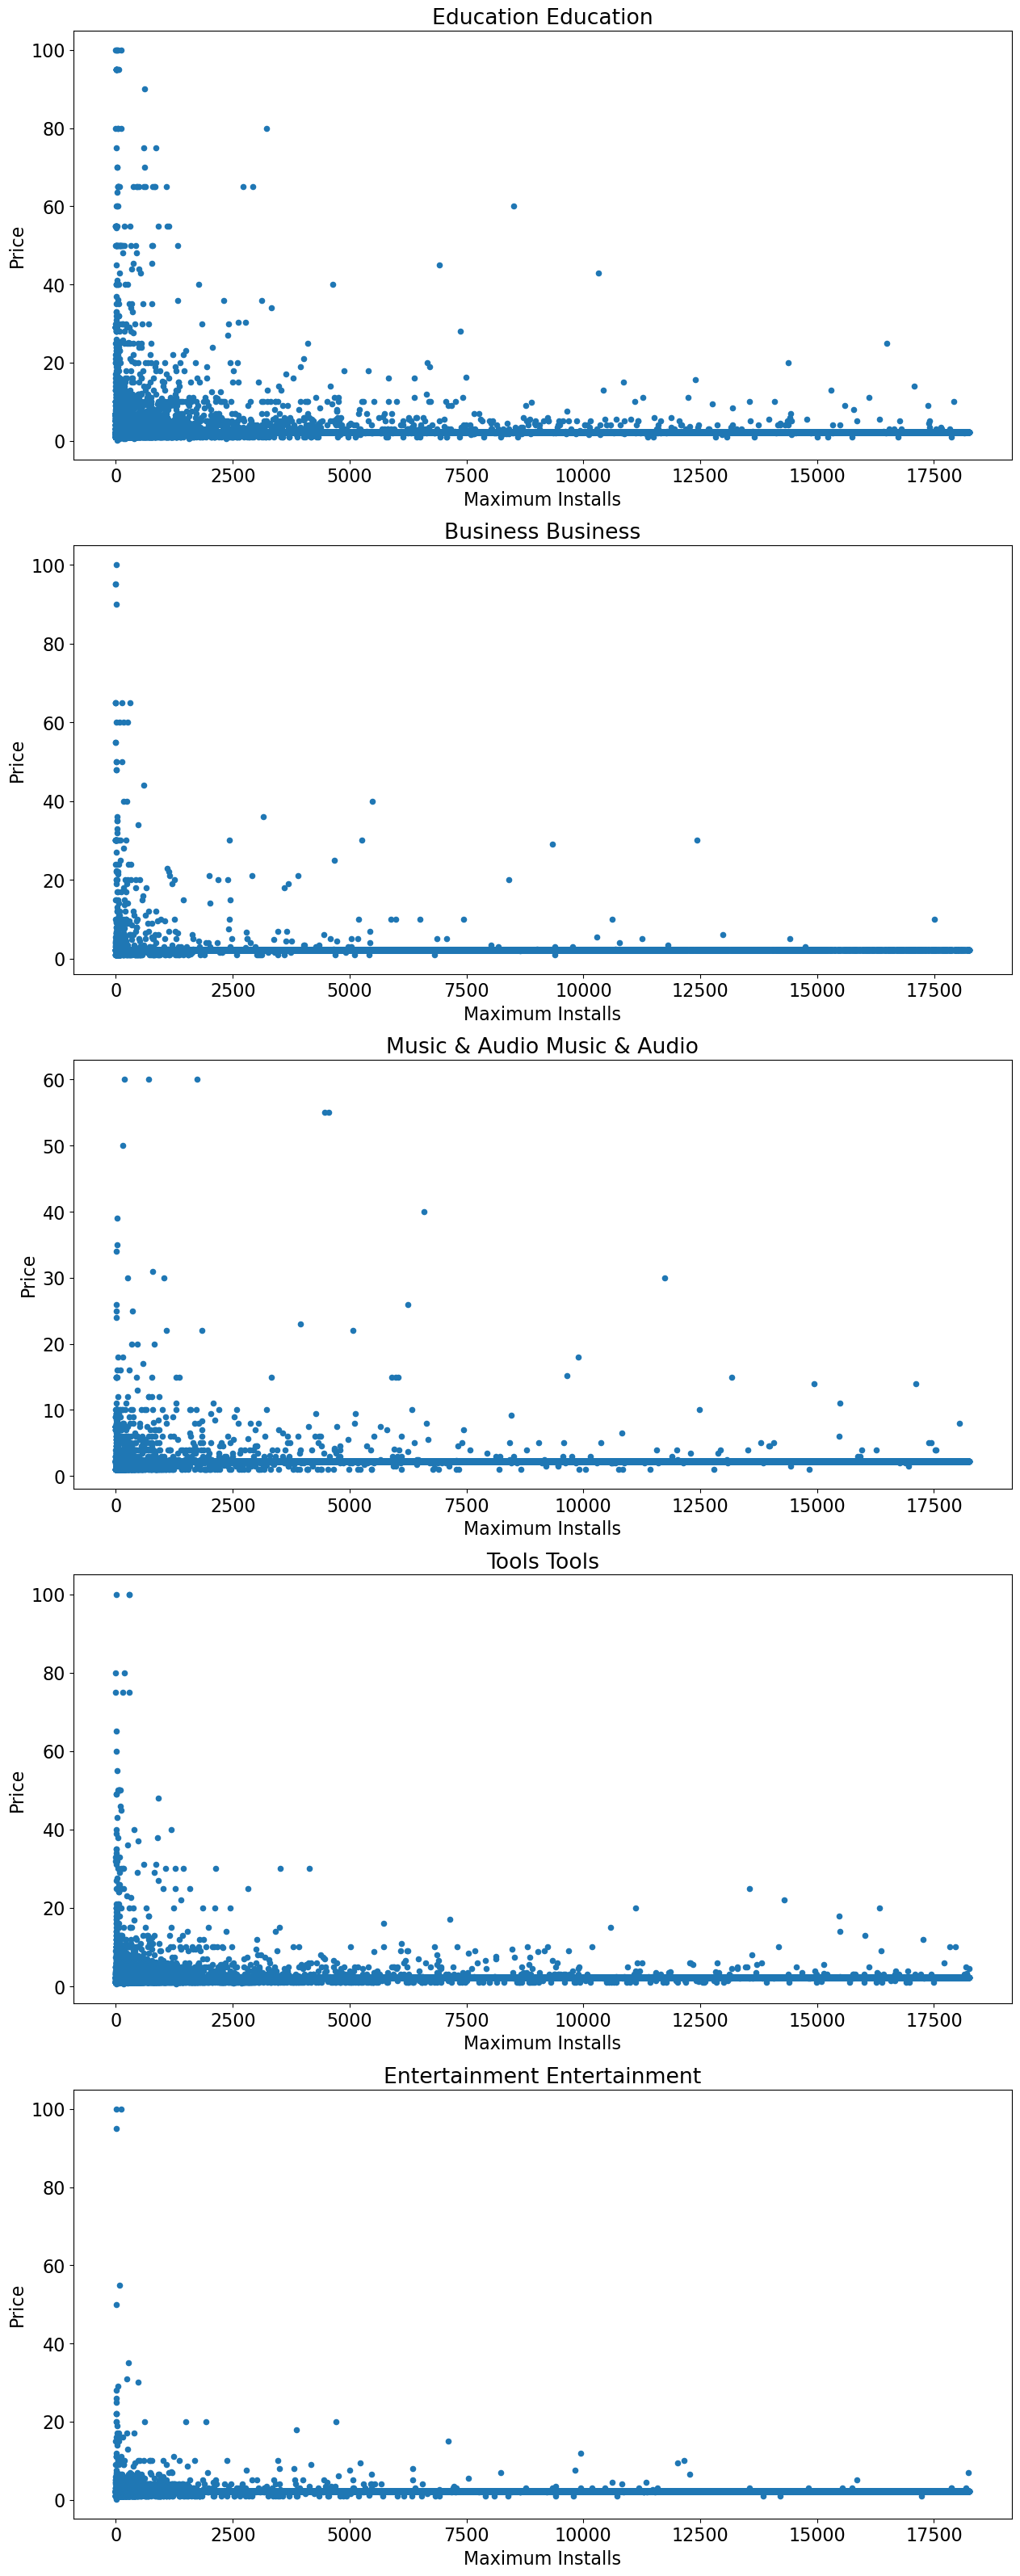

In [13]:
highest_app_category_df = df.select(df.Category, df['App Id']) \
    .groupBy(df.Category) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()
fig, axs = plt.subplots(nrows=5, figsize=(15,40))

for i in range(5):
    sub_df = df.select(df.Price, df["Maximum Installs"], ) \
                .filter((df.Category == highest_app_category_df.iloc[i]['Category']) & (df.Price<100) & (df["Maximum Installs"]<400000)) \
                .toPandas()
    q = sub_df.plot.scatter(x='Maximum Installs', y='Price', ax=axs[i])
    a, b = np.polyfit(sub_df['Maximum Installs'], sub_df['Price'], 1)
    e = axs[i].set_title(highest_app_category_df.iloc[i]['Category'] + ' ' + highest_app_category_df.iloc[i]['Category'])

### Cтатистика по скачиваниям для каждой категории приложения

In [14]:
category_prices_statistic_df = []
all_category = df.select(df.Category) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()
for category in all_category:
    stat_dict = {'Category': category}
    category_prices_df = df.select(df['Maximum Installs']).filter(df.Category==category)
    stats = category_prices_df.select(
        percentile_approx(df['Maximum Installs'],[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('Maximum Installs').alias('min'),
        max('Maximum Installs').alias('max'),
        mean('Maximum Installs').alias('mean'),
        stddev('Maximum Installs').alias('stddev'),
    ).collect()[0]
    
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    category_prices_statistic_df.append(stat_dict)
    
category_prices_statistic_df = pd.DataFrame(category_prices_statistic_df)
category_prices_statistic_df

,Category,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,Music & Audio,70,414,2156,10805,0,18258,2056.164176,3572.913007
1,Education,68,372,1938,10649,0,18258,1963.130443,3520.737159
2,Trivia,60,390,2310,11315,0,18246,2152.717447,3715.212296
3,Auto & Vehicles,61,382,1990,10539,0,18226,1954.328041,3480.518990
4,Entertainment,99,603,2984,12264,0,18258,2497.032802,3947.232396
...,...,...,...,...,...,...,...,...,...
56,com.conduit.app_f5a7d0bc78e84e30918dde02291e57...,100,100,100,100,100,100,100.000000,NaN
57,com.vsoapp.polls,5000,5000,5000,5000,5000,5000,5000.000000,NaN
58,com.hdibharatnews.app,100,100,100,100,100,100,100.000000,NaN
59,com.ud.parchis.publi,10000,10000,10000,10000,10000,10000,10000.000000,NaN


### Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение).

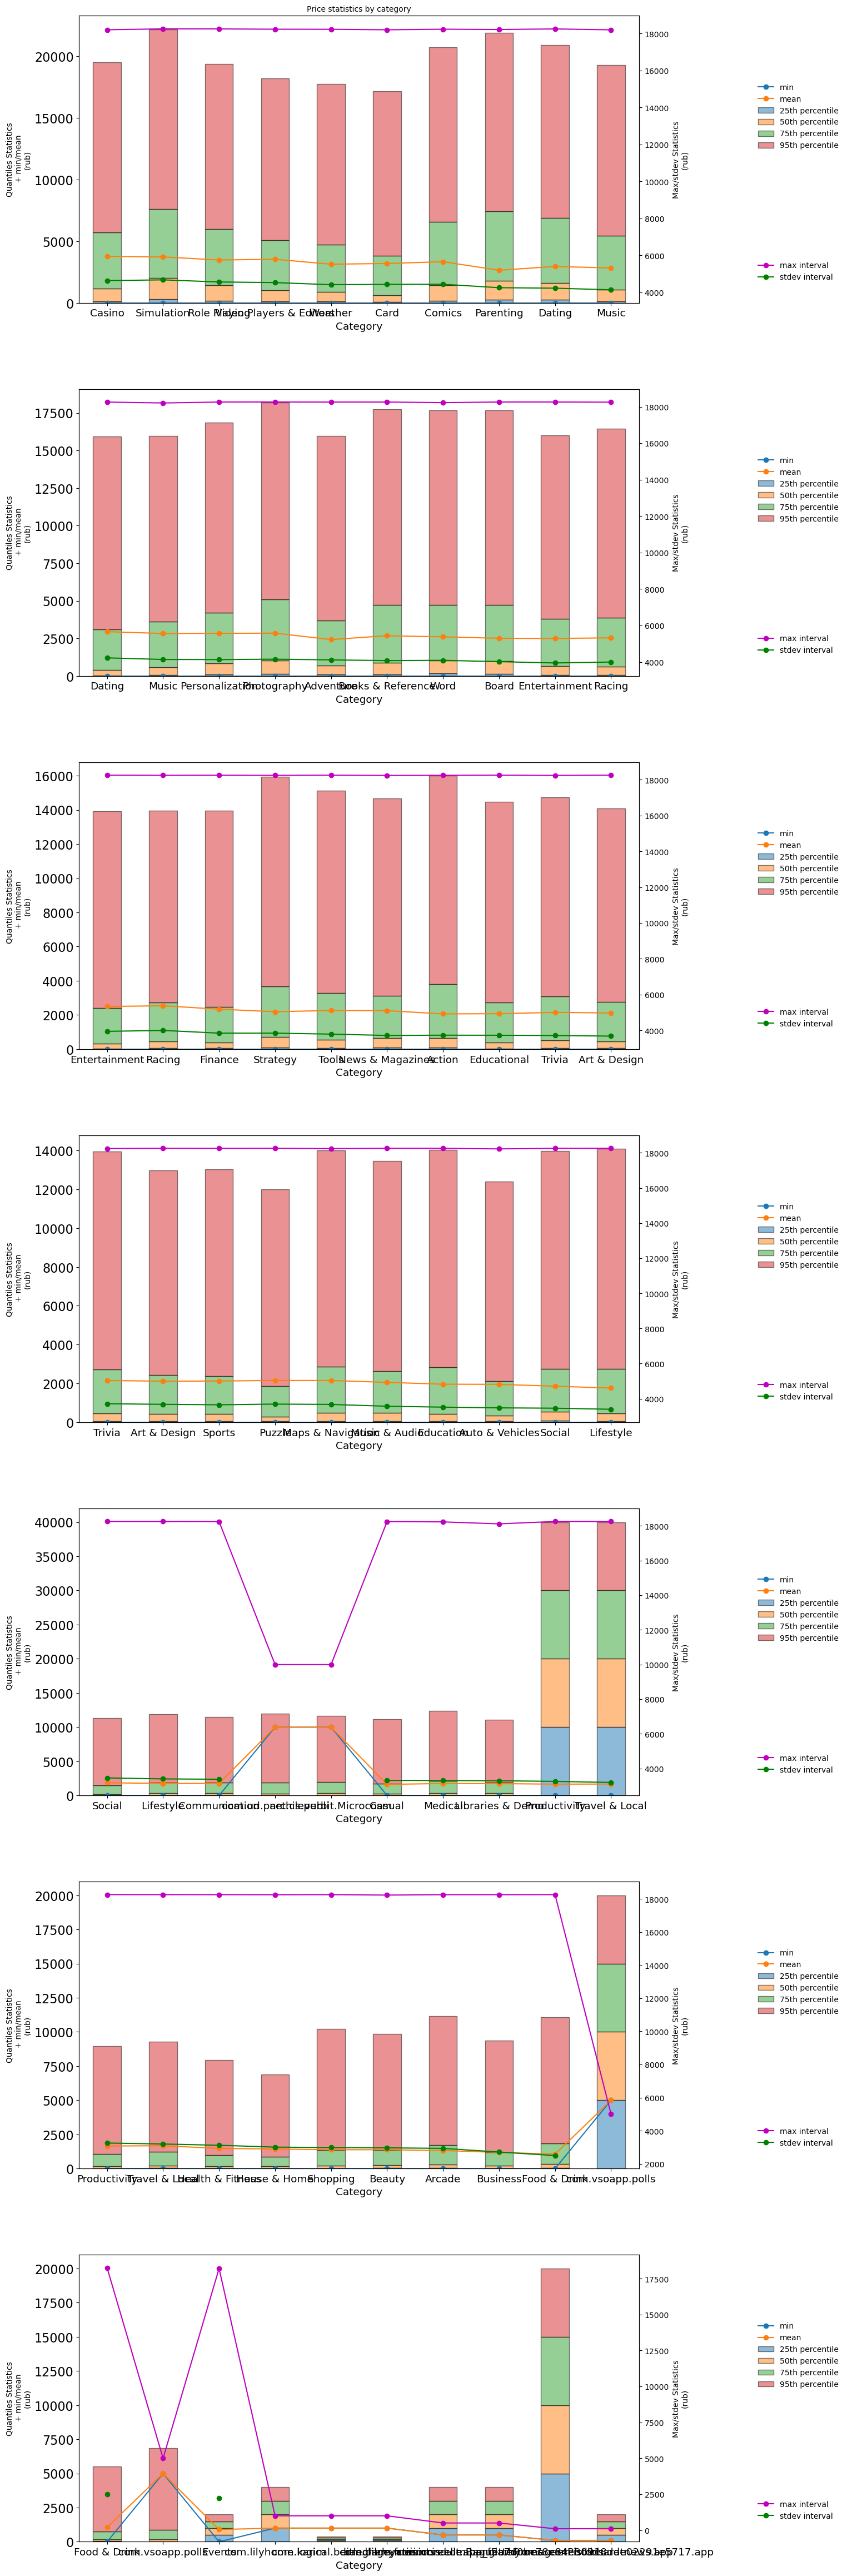

In [15]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
category_prices_statistic_df = category_prices_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_category)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Price statistics by category', fontsize=10)
for i in range (nrows):
    category_install_statistic_sub_df = category_prices_statistic_df.iloc[i*8:i*8+10,]
    plot1 = category_install_statistic_sub_df[['Category'] + bar_columns] \
        .groupby(['Category']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = category_install_statistic_sub_df[['Category'] + line_columns1].plot(x='Category', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = category_install_statistic_sub_df[['Category'] + line_columns2].plot( x='Category', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=10, bbox_to_anchor=(1.2, 0.65), frameon=False)
    a = ax2.legend(  labels=['max interval', 'stdev interval']
                   , loc="center left", fontsize=10, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(category_install_statistic_sub_df['Category'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Category', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics\n + min/mean\n(rub)', fontsize=10);
    e = ax2.set_ylabel('Max/stdev Statistics\n(rub)', fontsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();